In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as ltb
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from time import process_time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [40]:
coffee_df = pd.read_csv("Datasets/df_arabica_clean.csv")
coffee_df.head()

,Unnamed: 0,ID,Country of Origin,Farm Name,Lot Number,Mill,ICO Number,Company,Altitude,Region,...,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects,Expiration,Certification Body,Certification Address,Certification Contact
0,0,0,Colombia,Finca El Paraiso,CQU2022015,Finca El Paraiso,NaN,Coffee Quality Union,1700-1930,"Piendamo,Cauca",...,89.33,11.80,0,0,green,3,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
1,1,1,Taiwan,Royal Bean Geisha Estate,"The 2022 Pacific Rim Coffee Summit,T037",Royal Bean Geisha Estate,NaN,Taiwan Coffee Laboratory,1200,Chiayi,...,87.58,10.50,0,0,blue-green,0,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
2,2,2,Laos,OKLAO coffee farms,"The 2022 Pacific Rim Coffee Summit,LA01",oklao coffee processing plant,NaN,Taiwan Coffee Laboratory,1300,Laos Borofen Plateau,...,87.42,10.40,0,0,yellowish,2,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
3,3,3,Costa Rica,La Cumbre,CQU2022017,La Montana Tarrazu MIll,NaN,Coffee Quality Union,1900,"Los Santos,Tarrazu",...,87.17,11.80,0,0,green,0,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
4,4,4,Colombia,Finca Santuario,CQU2023002,Finca Santuario,NaN,Coffee Quality Union,1850-2100,"Popayan,Cauca",...,87.08,11.60,0,2,yellow-green,2,"March 5th, 2024",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901


In [3]:
prep_coffee_df = coffee_df[["Total Cup Points","Aroma","Flavor","Aftertaste","Acidity","Body","Balance","Uniformity","Clean Cup", "Sweetness"]]
prep_coffee_df.head()

,Total Cup Points,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness
0,89.33,8.58,8.50,8.42,8.58,8.25,8.42,10.0,10.0,10.0
1,87.58,8.50,8.50,7.92,8.00,7.92,8.25,10.0,10.0,10.0
2,87.42,8.33,8.42,8.08,8.17,7.92,8.17,10.0,10.0,10.0
3,87.17,8.08,8.17,8.17,8.25,8.17,8.08,10.0,10.0,10.0
4,87.08,8.33,8.33,8.08,8.25,7.92,7.92,10.0,10.0,10.0


The columns selected for the prep_coffee_df are the features that affect the total cup points. These features are what will be used to create the models to predict the total cup points.

In [4]:
coffee_df["Total Cup Points"].round().value_counts()

84.0    49
85.0    39
83.0    39
82.0    34
86.0    20
80.0     9
87.0     7
81.0     6
78.0     2
89.0     1
88.0     1
Name: Total Cup Points, dtype: int64

In [5]:
prep_coffee_df["Total Cup Points"] = prep_coffee_df["Total Cup Points"].round()
prep_coffee_df["Total Cup Points"].value_counts()

C:\Users\cabon\AppData\Local\Temp\ipykernel_13656\4068907721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_coffee_df["Total Cup Points"] = prep_coffee_df["Total Cup Points"].round()


84.0    49
85.0    39
83.0    39
82.0    34
86.0    20
80.0     9
87.0     7
81.0     6
78.0     2
89.0     1
88.0     1
Name: Total Cup Points, dtype: int64

We begin binning the data since Pycaret requires that there are more than just one count of a value.

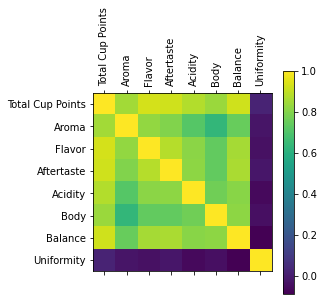

In [6]:
mat_df = prep_coffee_df.iloc[:, 0:8]
plt.matshow(mat_df.corr())
plt.xticks(np.arange(8), mat_df.columns, rotation=90)
plt.yticks(np.arange(8), mat_df.columns, rotation=0)
plt.colorbar()
plt.show()

<AxesSubplot:>

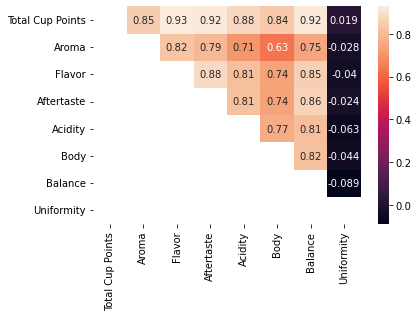

In [7]:
matrix = np.tril(prep_coffee_df.iloc[:, 0:8].corr())
sns.heatmap(prep_coffee_df.iloc[:, 0:8].corr(), annot=True, mask=matrix)

Above we see that the features that determine the total cup points almost all have a postive correlation. However, we can also see that the uniformity has essentially no correlation to it. Normally, I would remove this feature since it wouldn't really aid in creating an accurate model. Since it is used to determine the total cup points, I will leave it in for this occasion.

## Pycaret

In [8]:
import pycaret
from pycaret.classification import setup, compare_models, pull

In [9]:
df_py = prep_coffee_df.copy(deep=True)
df_py["Total Cup Points"] = df_py["Total Cup Points"].replace([88, 89], 88.5)
df_py["Total Cup Points"].value_counts()

84.0    49
85.0    39
83.0    39
82.0    34
86.0    20
80.0     9
87.0     7
81.0     6
88.5     2
78.0     2
Name: Total Cup Points, dtype: int64

In [10]:
df_py["Total Cup Points"] = df_py["Total Cup Points"].astype(str)
df_py["Total Cup Points"]

0      88.5
1      88.5
2      87.0
3      87.0
4      87.0
       ... 
202    80.0
203    80.0
204    80.0
205    78.0
206    78.0
Name: Total Cup Points, Length: 207, dtype: object

Further binning is done due to the reason I stated previously. Now, the reason why the Total Cup Points' variable type is changed to string is because there was conflicts keeping it as a float or integer. If it was kept as a either, the setup will not run fully.

In [11]:
grid = setup(data=df_py, target="Total Cup Points", html=False, verbose=False)
best = compare_models(errors="raise")
print(best)

                                    Model  Accuracy  AUC  Recall   Prec.  \
lda          Linear Discriminant Analysis    0.8543  0.0  0.8543  0.8633   
et                 Extra Trees Classifier    0.7919  0.0  0.7919  0.7802   
rf               Random Forest Classifier    0.7843  0.0  0.7843  0.7869   
knn                K Neighbors Classifier    0.7838  0.0  0.7838  0.7748   
xgboost         Extreme Gradient Boosting    0.7705  0.0  0.7705  0.7790   
lightgbm  Light Gradient Boosting Machine    0.7552  0.0  0.7552  0.7489   
gbc          Gradient Boosting Classifier    0.7490  0.0  0.7490  0.7626   
dt               Decision Tree Classifier    0.7438  0.0  0.7438  0.7607   
nb                            Naive Bayes    0.6610  0.0  0.6610  0.5559   
lr                    Logistic Regression    0.5190  0.0  0.5190  0.4365   
ridge                    Ridge Classifier    0.4081  0.0  0.4081  0.3047   
ada                  Ada Boost Classifier    0.3681  0.0  0.3681  0.1607   
svm         

In [12]:
best = pull()
best

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8543,0.0,0.8543,0.8633,0.8424,0.8232,0.8317,0.225
et,Extra Trees Classifier,0.7919,0.0,0.7919,0.7802,0.7720,0.7474,0.7577,0.311
rf,Random Forest Classifier,0.7843,0.0,0.7843,0.7869,0.7627,0.7379,0.7521,0.295
knn,K Neighbors Classifier,0.7838,0.0,0.7838,0.7748,0.7607,0.7373,0.7475,0.503
xgboost,Extreme Gradient Boosting,0.7705,0.0,0.7705,0.7790,0.7535,0.7214,0.7312,0.283
lightgbm,Light Gradient Boosting Machine,0.7552,0.0,0.7552,0.7489,0.7363,0.7031,0.7122,1.239
gbc,Gradient Boosting Classifier,0.7490,0.0,0.7490,0.7626,0.7255,0.6963,0.7146,0.597
dt,Decision Tree Classifier,0.7438,0.0,0.7438,0.7607,0.7253,0.6905,0.7060,0.205
nb,Naive Bayes,0.6610,0.0,0.6610,0.5559,0.5825,0.5930,0.6295,0.204
lr,Logistic Regression,0.5190,0.0,0.5190,0.4365,0.4408,0.4036,0.4331,1.142


In [13]:
df_pycaret = best[["Model", "Accuracy", "Recall", "Prec.", "F1", "TT (Sec)"]]
df_pycaret["Model"] = df_pycaret["Model"].apply(lambda x: x.replace(" ", ""))
df_pycaret

,Model,Accuracy,Recall,Prec.,F1,TT (Sec)
lda,LinearDiscriminantAnalysis,0.8543,0.8543,0.8633,0.8424,0.225
et,ExtraTreesClassifier,0.7919,0.7919,0.7802,0.7720,0.311
rf,RandomForestClassifier,0.7843,0.7843,0.7869,0.7627,0.295
knn,KNeighborsClassifier,0.7838,0.7838,0.7748,0.7607,0.503
xgboost,ExtremeGradientBoosting,0.7705,0.7705,0.7790,0.7535,0.283
lightgbm,LightGradientBoostingMachine,0.7552,0.7552,0.7489,0.7363,1.239
gbc,GradientBoostingClassifier,0.7490,0.7490,0.7626,0.7255,0.597
dt,DecisionTreeClassifier,0.7438,0.7438,0.7607,0.7253,0.205
nb,NaiveBayes,0.6610,0.6610,0.5559,0.5825,0.204
lr,LogisticRegression,0.5190,0.5190,0.4365,0.4408,1.142


In [14]:
df_pycaret["Library"] = "Pycaret"
df_pycaret = df_pycaret.rename(columns={"TT (Sec)": "Time Taken (Sec)"})
df_pycaret

,Model,Accuracy,Recall,Prec.,F1,Time Taken (Sec),Library
lda,LinearDiscriminantAnalysis,0.8543,0.8543,0.8633,0.8424,0.225,Pycaret
et,ExtraTreesClassifier,0.7919,0.7919,0.7802,0.7720,0.311,Pycaret
rf,RandomForestClassifier,0.7843,0.7843,0.7869,0.7627,0.295,Pycaret
knn,KNeighborsClassifier,0.7838,0.7838,0.7748,0.7607,0.503,Pycaret
xgboost,ExtremeGradientBoosting,0.7705,0.7705,0.7790,0.7535,0.283,Pycaret
lightgbm,LightGradientBoostingMachine,0.7552,0.7552,0.7489,0.7363,1.239,Pycaret
gbc,GradientBoostingClassifier,0.7490,0.7490,0.7626,0.7255,0.597,Pycaret
dt,DecisionTreeClassifier,0.7438,0.7438,0.7607,0.7253,0.205,Pycaret
nb,NaiveBayes,0.6610,0.6610,0.5559,0.5825,0.204,Pycaret
lr,LogisticRegression,0.5190,0.5190,0.4365,0.4408,1.142,Pycaret


The columns are renamed so that it'll make it easier to combine with the other dataframes. The new columns is made to make it easier to compare the data.

## Train_test_split

In [15]:
y_py = df_py["Total Cup Points"]
X_py = df_py.drop("Total Cup Points", axis=1)
X_py_train, X_py_test, y_py_train, y_py_test = train_test_split(X_py, y_py, random_state=42)
X_py_train.head()

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness
29,8.00,7.92,8.00,7.83,7.67,8.00,10.0,10.0,10.0
19,8.17,8.00,7.92,7.92,8.17,7.75,10.0,10.0,10.0
55,7.67,7.92,7.92,7.83,7.75,7.83,10.0,10.0,10.0
93,7.67,7.92,7.58,7.75,7.67,7.58,10.0,10.0,10.0
180,7.33,7.42,7.33,7.42,7.58,7.42,10.0,10.0,10.0


In [16]:
scaler = StandardScaler().fit(X_py_train)
X_py_train_scaled = scaler.transform(X_py_train)
X_py_test_scaled = scaler.transform(X_py_test)

## Lazypredict

In [17]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [18]:
clf_laz_str = LazyClassifier(verbose=0, ignore_warnings=True)
lazy_model_str, lazy_pred_str = clf_laz_str.fit(X_py_train_scaled, X_py_test_scaled, y_py_train, y_py_test)
lazy_model_str

 76%|██████████████████████████████████████████████████████████████▏                   | 22/29 [00:00<00:00, 36.27it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 155, number of used features: 6
[LightGBM] [Info] Start training from score -5.043425
[LightGBM] [Info] Start training from score -3.251666
[LightGBM] [Info] Start training from score -3.657131
[LightGBM] [Info] Start training from score -1.824549
[LightGBM] [Info] Start training from score -1.676129
[LightGBM] [Info] Start training from score -1.488077
[LightGBM] [Info] Start training from score -1.577689
[LightGBM] [Info] Start training from score -2.404368
[LightGBM] [Info] Start training from score -3.097515
[LightGBM] [Info] Start training from score -4.350278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 25.78it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearDiscriminantAnalysis,0.79,0.85,None,0.80,0.01
LGBMClassifier,0.79,0.79,None,0.79,0.39
NearestCentroid,0.85,0.78,None,0.85,0.01
RandomForestClassifier,0.87,0.74,None,0.85,0.14
ExtraTreeClassifier,0.67,0.71,None,0.68,0.01
ExtraTreesClassifier,0.81,0.70,None,0.79,0.08
LabelPropagation,0.79,0.68,None,0.78,0.01
LabelSpreading,0.79,0.68,None,0.78,0.01
BaggingClassifier,0.77,0.68,None,0.76,0.02


In [19]:
df_lazypred = lazy_model_str[["Accuracy", "Balanced Accuracy", "F1 Score", "Time Taken"]]
df_lazypred = df_lazypred.reset_index()
df_lazypred = df_lazypred.rename(columns={"Time Taken": "Time Taken (Sec)"})
df_lazypred["Library"] = "Lazypredict"
df_lazypred

,Model,Accuracy,Balanced Accuracy,F1 Score,Time Taken (Sec),Library
0,LinearDiscriminantAnalysis,0.79,0.85,0.80,0.01,Lazypredict
1,LGBMClassifier,0.79,0.79,0.79,0.39,Lazypredict
2,NearestCentroid,0.85,0.78,0.85,0.01,Lazypredict
3,RandomForestClassifier,0.87,0.74,0.85,0.14,Lazypredict
4,ExtraTreeClassifier,0.67,0.71,0.68,0.01,Lazypredict
5,ExtraTreesClassifier,0.81,0.70,0.79,0.08,Lazypredict
6,LabelPropagation,0.79,0.68,0.78,0.01,Lazypredict
7,LabelSpreading,0.79,0.68,0.78,0.01,Lazypredict
8,BaggingClassifier,0.77,0.68,0.76,0.02,Lazypredict
9,SVC,0.83,0.67,0.81,0.01,Lazypredict


## Model Testing

In [20]:
model_scores = []

model_scores will be where we keep the performance of each model.

In [21]:
classifier_lbfgs = LogisticRegression(solver='lbfgs', max_iter=100)
start = process_time()
classifier_lbfgs.fit(X_py_train_scaled, y_py_train)
end = process_time()
model_scores.append(["LogisticRegression", classifier_lbfgs.score(X_py_train_scaled, y_py_train), classifier_lbfgs.score(X_py_test_scaled, y_py_test), end - start])

print(f"Training Model Score: {classifier_lbfgs.score(X_py_train_scaled, y_py_train)}")
print(f"Testing Model Score: {classifier_lbfgs.score(X_py_test_scaled, y_py_test)}")

Training Model Score: 0.832258064516129
Testing Model Score: 0.7115384615384616


In [22]:
clf_3 = DecisionTreeClassifier(random_state=42)
start = process_time()
clf_3.fit(X_py_train_scaled, y_py_train)
end = process_time()
model_scores.append(["DecisionTreeClassifier", clf_3.score(X_py_train_scaled, y_py_train), clf_3.score(X_py_test_scaled, y_py_test), end - start])

print(f"Training Model Score: {clf_3.score(X_py_train_scaled, y_py_train)}")
print(f"Testing Model Score: {clf_3.score(X_py_test_scaled, y_py_test)}")

Training Model Score: 1.0
Testing Model Score: 0.7692307692307693


In [23]:
rf_py = RandomForestClassifier()
start = process_time()
rf_py.fit(X_py_train_scaled, y_py_train)
end = process_time()
#y_py_pred_rf = rf.predict(X_py_test_scaled)
model_scores.append(["RandomForestClassifier", rf_py.score(X_py_train_scaled, y_py_train), rf_py.score(X_py_test_scaled, y_py_test), end - start])

print(f"Training Model Score: {rf_py.score(X_py_train_scaled, y_py_train)}")
print(f"Testing Model Score: {rf_py.score(X_py_test_scaled, y_py_test)}")

Training Model Score: 1.0
Testing Model Score: 0.8653846153846154


In [24]:
svc = SVC(kernel='rbf')
start = process_time()
svc.fit(X_py_train_scaled, y_py_train)
end = process_time()
model_scores.append(["SVC", svc.score(X_py_train_scaled, y_py_train), svc.score(X_py_test_scaled, y_py_test), end - start])

print(f"Training Model Score: {svc.score(X_py_train_scaled, y_py_train)}")
print(f"Testing Model Score: {svc.score(X_py_test_scaled, y_py_test)}")

Training Model Score: 0.8774193548387097
Testing Model Score: 0.8269230769230769


In [25]:
model_lda = LinearDiscriminantAnalysis()
start = process_time()
model_lda.fit(X_py_train_scaled, y_py_train)
end = process_time()
model_scores.append(["LinearDiscriminantAnalysis", model_lda.score(X_py_train_scaled, y_py_train), model_lda.score(X_py_test_scaled, y_py_test), end - start])

print(f"Training Model Score: {model_lda.score(X_py_train_scaled, y_py_train)}")
print(f"Testing Model Score: {model_lda.score(X_py_test_scaled, y_py_test)}")

Training Model Score: 0.9290322580645162
Testing Model Score: 0.7884615384615384


In [26]:
model_etc = ExtraTreesClassifier()
start = process_time()
model_etc.fit(X_py_train_scaled, y_py_train)
end = process_time()
model_scores.append(["ExtraTreesClassifier", model_etc.score(X_py_train_scaled, y_py_train), model_etc.score(X_py_test_scaled, y_py_test), end - start])

print(f"Training Model Score: {model_etc.score(X_py_train_scaled, y_py_train)}")
print(f"Testing Model Score: {model_etc.score(X_py_test_scaled, y_py_test)}")

Training Model Score: 1.0
Testing Model Score: 0.7884615384615384


In [27]:
model_ltb = ltb.LGBMClassifier()
start = process_time()
model_ltb.fit(X_py_train_scaled, y_py_train)
end = process_time()
model_scores.append(["LGBMClassifier", model_ltb.score(X_py_train_scaled, y_py_train), model_ltb.score(X_py_test_scaled, y_py_test), end - start])

print(f"Training Model Score: {model_ltb.score(X_py_train_scaled, y_py_train)}")
print(f"Testing Model Score: {model_ltb.score(X_py_test_scaled, y_py_test)}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 155, number of used features: 6
[LightGBM] [Info] Start training from score -5.043425
[LightGBM] [Info] Start training from score -3.251666
[LightGBM] [Info] Start training from score -3.657131
[LightGBM] [Info] Start training from score -1.824549
[LightGBM] [Info] Start training from score -1.676129
[LightGBM] [Info] Start training from score -1.488077
[LightGBM] [Info] Start training from score -1.577689
[LightGBM] [Info] Start training from score -2.404368
[LightGBM] [Info] Start training from score -3.097515
[LightGBM] [Info] Start training from score -4.350278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [28]:
model_knn = KNeighborsClassifier()
start = process_time()
model_knn.fit(X_py_train_scaled, y_py_train)
end = process_time()
model_scores.append(["KNeighborsClassifier", model_knn.score(X_py_train_scaled, y_py_train), model_knn.score(X_py_test_scaled, y_py_test), end - start])

print(f"Training Model Score: {model_knn.score(X_py_train_scaled, y_py_train)}")
print(f"Testing Model Score: {model_knn.score(X_py_test_scaled, y_py_test)}")

Training Model Score: 0.8193548387096774
Testing Model Score: 0.75


In [29]:
model_rid = RidgeClassifier()
start = process_time()
model_rid.fit(X_py_train_scaled, y_py_train)
end = process_time()
model_scores.append(["RidgeClassifier", model_rid.score(X_py_train_scaled, y_py_train), model_rid.score(X_py_test_scaled, y_py_test), end - start])

print(f"Training Model Score: {model_rid.score(X_py_train_scaled, y_py_train)}")
print(f"Testing Model Score: {model_rid.score(X_py_test_scaled, y_py_test)}")

Training Model Score: 0.5741935483870968
Testing Model Score: 0.40384615384615385


In [30]:
model_ada = AdaBoostClassifier()
start = process_time()
model_ada.fit(X_py_train_scaled, y_py_train)
end = process_time()
model_scores.append(["AdaBoostClassifier", model_ada.score(X_py_train_scaled, y_py_train), model_ada.score(X_py_test_scaled, y_py_test), end - start])

print(f"Training Model Score: {model_ada.score(X_py_train_scaled, y_py_train)}")
print(f"Testing Model Score: {model_ada.score(X_py_test_scaled, y_py_test)}")

Training Model Score: 0.38064516129032255
Testing Model Score: 0.2692307692307692


## Active Learning

In [31]:
def spl(ds, train_size, test_size):
    y = ds["Total Cup Points"]
    X = ds.drop("Total Cup Points", axis=1)
    X_train, X_pool, y_train, y_pool = train_test_split(X, y, train_size=train_size)
    unlabel, X_test, label, y_test = train_test_split(X_pool, y_pool, test_size=test_size)
    return X_train, y_train, X_test, y_test, unlabel, label

In [32]:
ac_1, ac_2 = [], []

for i in range(100):
    X_train, y_train, X_test, y_test, unlabel, label = spl(df_py, 0.30, 0.50)
    
    for j in range(5):
        model_lda_1 = LinearDiscriminantAnalysis()
        model_lda_1.fit(X_train, y_train)
        y_probab = model_lda_1.predict_proba(unlabel)[:, 0]
        p = 0.50
        uncrt_pt_ind = []
        for k in range(unlabel.shape[0]):
            if(y_probab[k] >= p and y_probab[k] <= 1-p):
                uncrt_pt_ind.append(k)
        X_train = np.append(unlabel.iloc[uncrt_pt_ind, :], X_train, axis=0)
        y_train = np.append(label[uncrt_pt_ind], y_train)
        unlabel = np.delete(unlabel, uncrt_pt_ind, axis=0)
        label = np.delete(label, uncrt_pt_ind)
    model_lda_2 = LinearDiscriminantAnalysis()
    model_lda_2.fit(X_train, y_train)
    ac_1.append(model_lda_2.score(X_test, y_test))
    
    train_size = X_train.shape[0]/df_py.shape[0]
    X_train, y_train, X_test, y_test, unlabel, label = spl(df_py, train_size, 0.50)
    model_lda_3 = LinearDiscriminantAnalysis()
    model_lda_3.fit(X_train, y_train)
    ac_2.append(model_lda_3.score(X_test, y_test))
    
print(f'Accuracy by active model: {np.mean(ac_1)*100}')
print(f'Accuracy by random sampling: {np.mean(ac_2)*100}')

Accuracy by active model: 77.67123287671232
Accuracy by random sampling: 76.82191780821918


## Merging Dataframes

In [33]:
column_names = ["Model", "Training Score", "Testing Score", "Time Taken (Sec)"]
df_scores = pd.DataFrame(data=model_scores, columns=column_names)
df_scores

,Model,Training Score,Testing Score,Time Taken (Sec)
0,LogisticRegression,0.83,0.71,0.19
1,DecisionTreeClassifier,1.00,0.77,0.00
2,RandomForestClassifier,1.00,0.87,0.09
3,SVC,0.88,0.83,0.00
4,LinearDiscriminantAnalysis,0.93,0.79,0.00
5,ExtraTreesClassifier,1.00,0.79,0.66
6,LGBMClassifier,1.00,0.79,2.20
7,KNeighborsClassifier,0.82,0.75,0.00
8,RidgeClassifier,0.57,0.40,0.09
9,AdaBoostClassifier,0.38,0.27,0.25


In [34]:
df_scores["Library"] = "None"
df_scores = df_scores.rename(columns={"Testing Score": "Accuracy"})
df_scores

,Model,Training Score,Accuracy,Time Taken (Sec),Library
0,LogisticRegression,0.83,0.71,0.19,None
1,DecisionTreeClassifier,1.00,0.77,0.00,None
2,RandomForestClassifier,1.00,0.87,0.09,None
3,SVC,0.88,0.83,0.00,None
4,LinearDiscriminantAnalysis,0.93,0.79,0.00,None
5,ExtraTreesClassifier,1.00,0.79,0.66,None
6,LGBMClassifier,1.00,0.79,2.20,None
7,KNeighborsClassifier,0.82,0.75,0.00,None
8,RidgeClassifier,0.57,0.40,0.09,None
9,AdaBoostClassifier,0.38,0.27,0.25,None


In [35]:
temp_dfs = [df_scores[["Library", "Model", "Accuracy", "Time Taken (Sec)"]], df_lazypred[["Library", "Model", "Accuracy", "Time Taken (Sec)"]], df_pycaret[["Library", "Model", "Accuracy", "Time Taken (Sec)"]]]
merged_df = pd.concat(temp_dfs).reset_index(drop=True)
merged_df

,Library,Model,Accuracy,Time Taken (Sec)
0,None,LogisticRegression,0.71,0.19
1,None,DecisionTreeClassifier,0.77,0.00
2,None,RandomForestClassifier,0.87,0.09
3,None,SVC,0.83,0.00
4,None,LinearDiscriminantAnalysis,0.79,0.00
5,None,ExtraTreesClassifier,0.79,0.66
6,None,LGBMClassifier,0.79,2.20
7,None,KNeighborsClassifier,0.75,0.00
8,None,RidgeClassifier,0.40,0.09
9,None,AdaBoostClassifier,0.27,0.25


In [36]:
cleaned_df = merged_df[merged_df["Model"].isin(["LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", "LinearDiscriminantAnalysis", 
                "ExtraTreesClassifier", "KNeighborsClassifier", "RidgeClassifier", "AdaBoostClassifier"])]
cleaned_df = cleaned_df.reset_index(drop=True)
cleaned_df

,Library,Model,Accuracy,Time Taken (Sec)
0,None,LogisticRegression,0.71,0.19
1,None,DecisionTreeClassifier,0.77,0.00
2,None,RandomForestClassifier,0.87,0.09
3,None,LinearDiscriminantAnalysis,0.79,0.00
4,None,ExtraTreesClassifier,0.79,0.66
5,None,KNeighborsClassifier,0.75,0.00
6,None,RidgeClassifier,0.40,0.09
7,None,AdaBoostClassifier,0.27,0.25
8,Lazypredict,LinearDiscriminantAnalysis,0.79,0.01
9,Lazypredict,RandomForestClassifier,0.87,0.14


The models that were selected are in both Lazypredict and Pycaret.

## Plots

In [37]:
sns.set_theme()

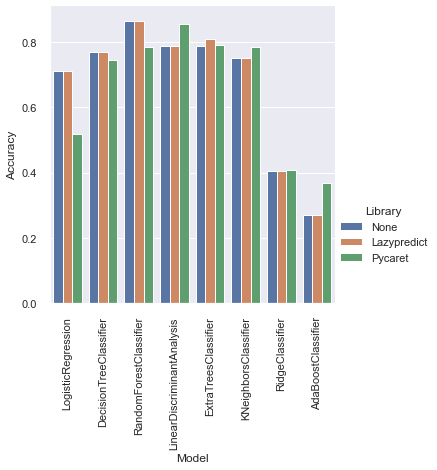

In [38]:
clust_bar = sns.catplot(data=cleaned_df, kind="bar", x="Model", y="Accuracy", hue="Library")
clust_bar.set_xticklabels(rotation=90)

I find this model to be quite interesting. It is quite clear that, both the models I made and the Lazypredict models mainly had the same accuracy. With Pycaret, it either went over or under the accuracy of the actual tests I ran.

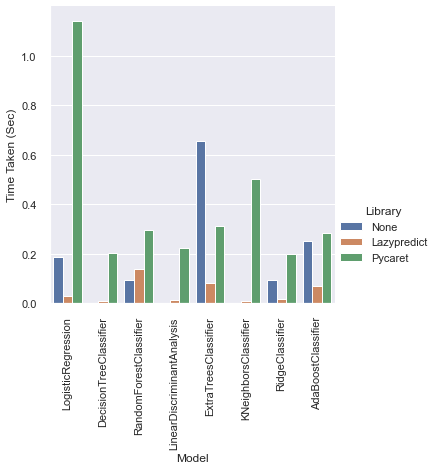

In [39]:
clust_bar = sns.catplot(data=cleaned_df, kind="bar", x="Model", y="Time Taken (Sec)", hue="Library")
clust_bar.set_xticklabels(rotation=90)

This to me is also quite interesting. We see that Lazypredict was usually faster in creating and testing the models compared to both Pycaret and manual creation.